<a href="https://colab.research.google.com/github/IssamBenamara/SIFT_BOW/blob/master/TP1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/tools.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_kmeans.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_sifts.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/sift.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/kmeans.py

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/data.zip -d /content/

# Partie 1 : SIFT

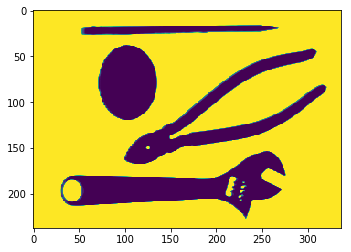

In [0]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

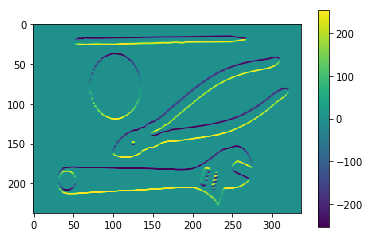

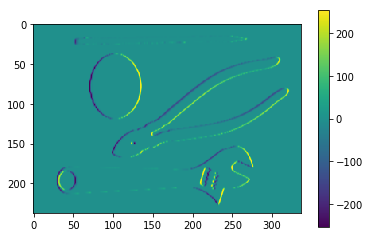

In [0]:
def compute_grad(I):
    h_x = 0.5*np.asarray([1,0,-1])
    h_y = 0.5*np.asarray([-1,-2,-1])
    Iy = conv_separable(I, h_x, h_y)
    Ix = conv_separable(I, h_y, h_x)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [0]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = np.sqrt(Ix**2+Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gm)
    return Gm, Go

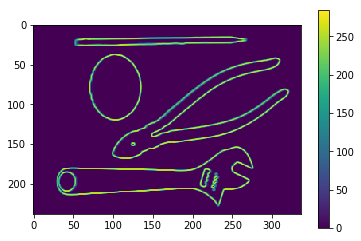

In [0]:
Gm, Go = compute_grad_mod_ori(I)
plt.imshow(Gm)
plt.colorbar()
plt.show()

In [0]:
def compute_sift_region(Gm, Go, mask=None):
    # Note: to apply the mask only when given, do:
    R = np.zeros((16,8))
    Gn = Gm.copy()
    if mask is not None:
        Gn = np.multiply(Gn, mask)
    for i in range(4):
        for j in range(4):
            Gn_region = Gn[j*4:j*4+4,i*4:i*4+4]
            Go_region = Go[j*4:j*4+4,i*4:i*4+4]

            for v in range(8):
                ind = np.where(Go_region==v)
                s = np.sum(Gn_region[ind[0],ind[1]])
                R[i*4+j][v] = s
    sift = R.ravel()
    norm = np.linalg.norm(sift)
    if norm < 0.5:
        return np.zeros(sift.shape)
    sift = sift/np.linalg.norm(sift)
    sift = np.clip(sift,0,0.2)
    sift = sift/np.linalg.norm(sift)
    return sift

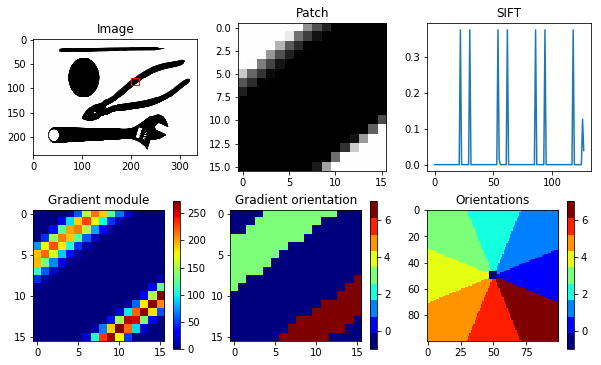

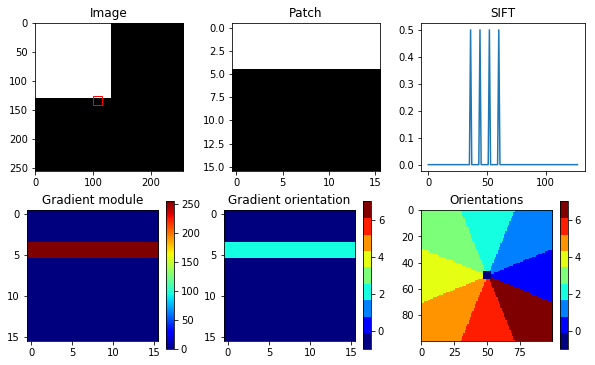

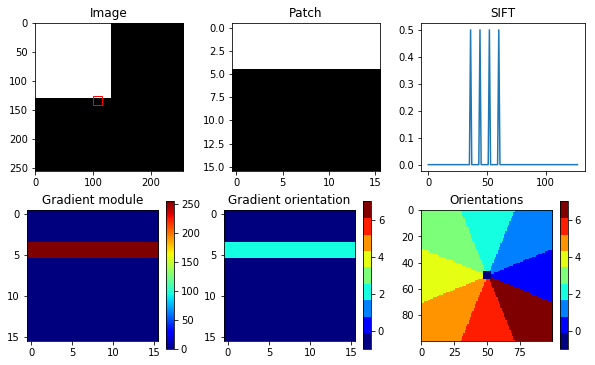

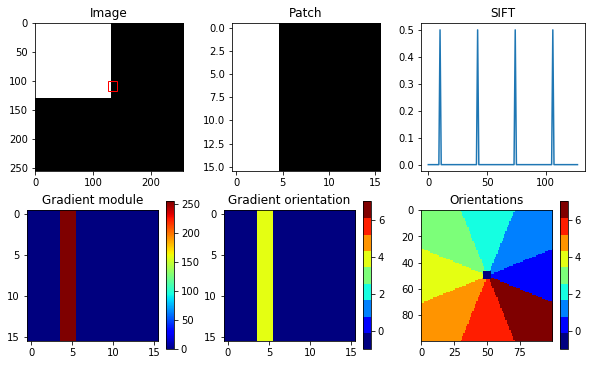

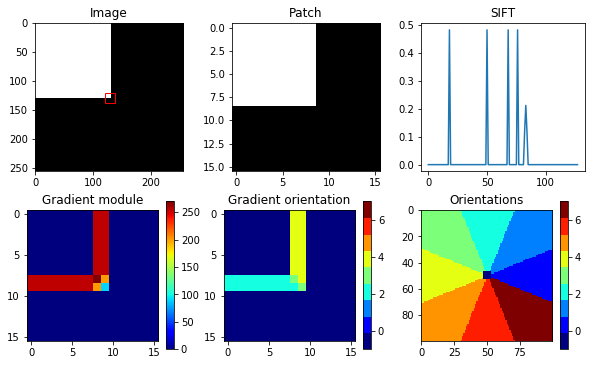

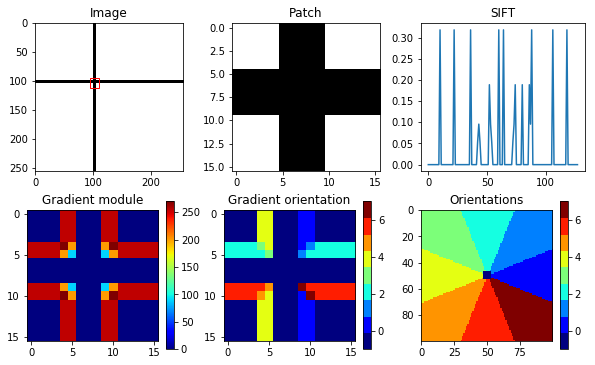

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18864812, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.18864

In [0]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [0]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    sifts = np.zeros((len(x), len(y), 128))
    Gn, Go = compute_grad_mod_ori(im)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            Gn_region = Gn[xi:xi+16,yj:yj+16]
            Go_region = Go[xi:xi+16,yj:yj+16]
            sifts[i, j, :] = compute_sift_region(Gn_region, Go_region) # TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

# Partie 2 : Dictionnaire visuel

In [0]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

In [0]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [86]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


KeyboardInterrupt: ignored

In [0]:
sift = sifts_list_by_image
dim_sift = sift[0].shape[-1]

In [0]:
sift = [s.reshape(-1, dim_sift) for s in sift]


In [82]:
sifts_list_by_image

[array([[[ 0,  0,  0, ..., 15, 85, 29],
         [ 0,  0,  0, ..., 28, 48, 60],
         [ 0,  0,  0, ..., 24, 29,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  0,  0, ...,  4,  7,  4],
         [ 1,  2,  9, ..., 20, 65, 65],
         [27,  0,  1, ...,  2, 16, 55],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  2],
         [ 0,  0,  0, ...,  1,  1,  2],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        ...,
 
        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0, 24, ...,  0,  0,  0],
         [ 0,  0,  8, ...,  0,  0,  0],
         ...,
         [ 0,  0, 47, ...,  5, 11, 15],
         [ 0,  0, 63, ...,  0,  6,  0],


In [76]:
sift

[array([[ 0,  0,  0, ..., 15, 85, 29],
        [ 0,  0,  0, ..., 28, 48, 60],
        [ 0,  0,  0, ..., 24, 29,  0],
        ...,
        [ 7,  8,  0, ...,  0,  0,  0],
        [ 0,  0,  5, ...,  0,  0,  0],
        [ 0,  0,  3, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0, 23, ...,  0,  0,  0],
        [ 0, 13, 16, ...,  0,  0,  0],
        [ 0,  0,  6, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0,  0, ..., 70, 70, 70],
        [ 0,  0,  0, ..., 48, 18, 24],
        [ 0,  0,  0, ...,  3,  3,  5],
        ...,
        [15, 32,  0, ...,  0,  0,  0],
        [ 0,  0, 21, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  1],
        [ 0,  0,  0, ...,  0,  0,  1],
        ...,
        [ 3, 21,  6, ...,  0,  0,  0],
        [ 4, 24, 39, ...,  0,  0,  0],
      

In [72]:
sift = np.concatenate(sift, axis=0)
keep = ~np.all(sift==0, axis=1)
sift = sift[keep]
ids, _ = compute_split(sift.shape[0], pc=0.05)
sift = sift[ids]
sift.shape

(11714, 128)

In [0]:
# Code here the `compute_visual_dict` function
from sklearn import metrics 
from sklearn.cluster import KMeans
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    kmeans = KMeans(n_clusters=n_clusters, n_init = n_init).fit(sift)
    cluster_centers = kmeans.cluster_centers_.tolist()
    cluster_centers.append([0]*(len(cluster_centers[0])))
    return np.asarray(cluster_centers)


In [9]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


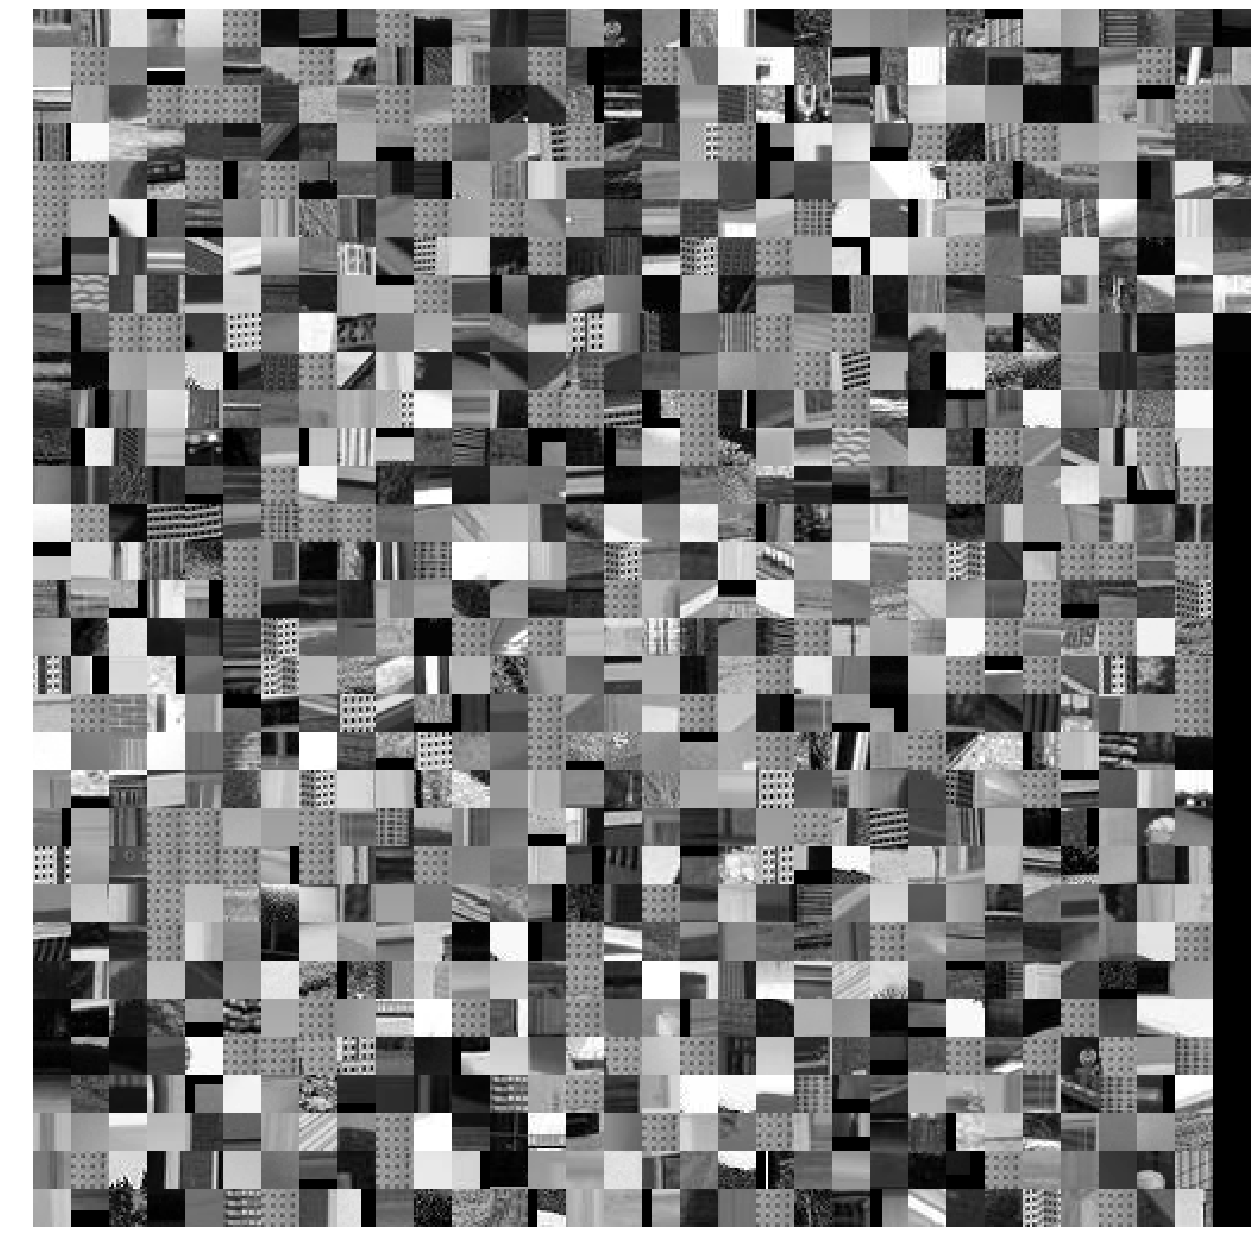

In [10]:
# Study of the dict
from scipy.spatial import distance_matrix

regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 100)) # Compute SIFT and regions from 30 random images
dm = distance_matrix(vidct,sifts)
ids = np.argmin(dm,axis=1)
display_images(regions[ids])

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

In [0]:
!zip -r data.zip data

In [0]:
!mv data.zip /content/drive/My\ Drive/

In [0]:
drive.mount('/content/drive')

Mounted at /content/drive


# Partie 3 : BoW

In [0]:
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 1))

In [30]:
sifts.shape, vidct.shape

((1024, 128), (1001, 128))

In [66]:
from scipy.spatial.distance import euclidean

dm = np.zeros((len(sifts),len(vidct)))
for i_s, s in enumerate(sifts):
    for i_d, d in enumerate(vidct):
        dm[i_s][i_d] = euclidean(s,d)
dm        

array([[183.32604668, 182.8518535 , 220.20594535, ..., 191.81076623,
        184.83245874,   1.        ],
       [183.2541761 , 182.83594571, 220.05950658, ..., 191.68125072,
        184.83583575,   1.        ],
       [183.2517625 , 182.84120155, 220.0650994 , ..., 191.67572631,
        184.8324389 ,   1.        ],
       ...,
       [183.16065083, 182.94691337, 219.97487322, ..., 191.60642954,
        184.49261507,   1.        ],
       [183.22360254, 182.89843944, 220.05014594, ..., 191.69503024,
        184.66420974,   1.        ],
       [183.28063954, 182.92955168, 220.13990104, ..., 191.87661711,
        184.61366198,   1.        ]])

In [67]:
vidct

array([[23.65128205, 10.04615385,  8.64615385, ...,  5.97435897,
        11.24102564,  6.91794872],
       [ 7.86813187,  5.7032967 ,  7.20879121, ..., 25.65384615,
        18.16483516, 13.20879121],
       [ 2.45982143,  5.79464286, 51.34821429, ...,  4.88839286,
        15.86607143,  4.79910714],
       ...,
       [ 9.13768116,  6.96014493, 10.94202899, ...,  4.34782609,
        10.84782609,  4.86231884],
       [ 8.23529412,  3.36134454,  5.83193277, ...,  9.23529412,
        27.8487395 ,  8.52941176],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [65]:
np.linalg.norm(sifts[0])

0.9999999999999999

In [0]:
from sklearn.metrics import pairwise_distances
pairwise_distances()

In [36]:
ids = np.argmin(dm,axis=1)
ids.shape

(1024,)

In [50]:
ids.max()

1000

In [44]:
mins.reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [38]:
np.zeros((len(ids),len(vidct))).shape

(1024, 1001)

In [0]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    return

In [0]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here